In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px


In [2]:
# Ignore certain warnings
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [3]:
df_nyc = pd.read_csv('nyc_cleaned.csv', low_memory=False)

In [4]:
# Get statistics on cleaned dataframe
print(len(df_nyc))
print(df_nyc['Property ID'].nunique())

200225
38350


In [5]:
# Building count details
df_sqft = df_nyc.sort_values('year').drop_duplicates('Property ID', keep='last')[['Primary Property Type - Self Selected','sqft']]

building_counts = df_sqft.groupby('Primary Property Type - Self Selected')['sqft'].count()

building_counts.sort_values(ascending=False)

Primary Property Type - Self Selected
Multifamily Housing                                      24723
Office                                                    3161
K-12 School                                               2133
Hotel                                                      849
Non-Refrigerated Warehouse                                 622
                                                         ...  
Supermarché/épicerie                                         1
Indoor Arena                                                 1
Convention Center                                            1
Convenience Store without Gas Station                        1
Personal Services (Health/Beauty, Dry Cleaning, etc.)        1
Name: sqft, Length: 79, dtype: int64

C:\Users\etien\AppData\Local\Temp\ipykernel_2340\1001140336.py:16: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\etien\AppData\Local\Temp\ipykernel_2340\1001140336.py:17: FutureWarning:

ChainedAssignmentError: behaviour will change

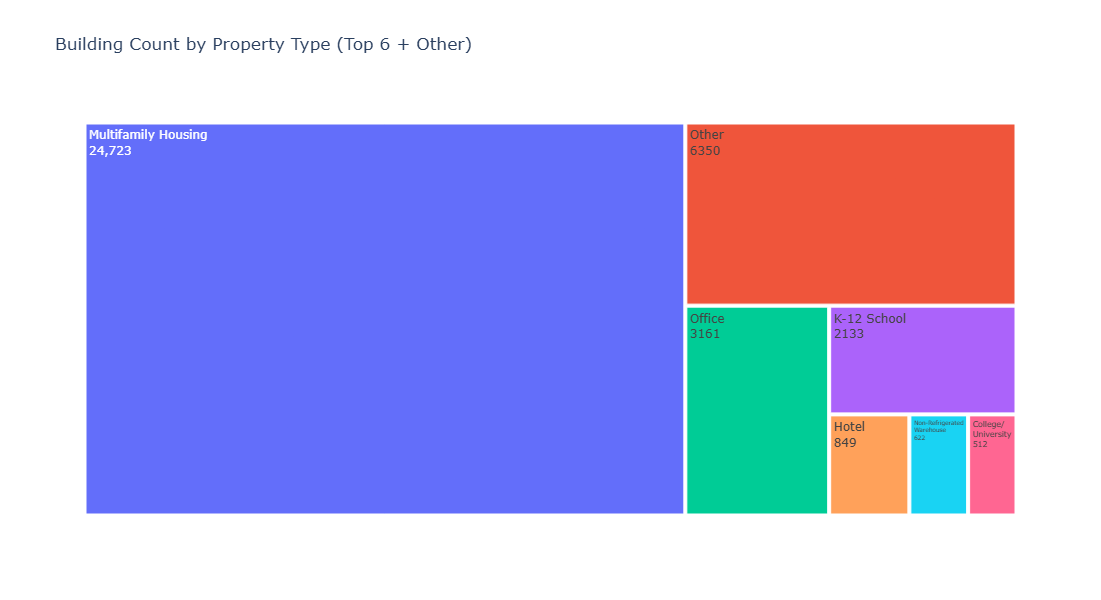

In [29]:
# Make a treegraph

# Sort and get the top 6
top_6 = building_counts.sort_values(ascending=False).head(6)

# Sum the rest and create a new Series for 'Other'
other_sum = building_counts[~building_counts.index.isin(top_6.index)].sum()
other_series = pd.Series({'Other': other_sum})

# Concatenate the two
building_counts_final = pd.concat([top_6, other_series])

# Convert Series to DataFrame with proper column names
df_treemap = building_counts_final.reset_index()
df_treemap.columns = ['Property Type', 'Count']

# Add line breaks for long text
df_treemap['Property Type'].iloc[4] = 'Non-Refrigerated<br>Warehouse'
df_treemap['Property Type'].iloc[5] = 'College/<br>University'

# Create the treemap using the wrapped labels
fig = px.treemap(
    df_treemap,
    path=['Property Type'],
    values='Count',
    title="Building Count by Property Type (Top 6 + Other)",
    width=1000,
    height=600
)

fig.update_traces(textinfo="label+value")

fig.show()

In [31]:
# Array of building types with 500+ unique buildings 
most_common_buildings = ['Multifamily Housing','Office','K-12 School','Hotel','Non-Refrigerated Warehouse','College/University']

In [17]:
# Narrow down features

current_features = [
    'Property ID',
    'year',
    'age',
    'Primary Property Type - Self Selected',
    'ln_source_eui',
    'Weather Normalized Source EUI (kBtu/ft²)',
    'ln_nat_med_eui',
    'Weather Normalized Source Energy Use (kBtu)',
    'sqft',
    'numfloors',
    'Electricity Use (kBtu)',
    'Natural Gas Use (kBtu)',
    'District Steam Use (kBtu)',
    'Electricity Use (kBtu)_ratio',
    'Natural Gas Use (kBtu)_ratio',
    'District Steam Use (kBtu)_ratio',
    'electricity_primary',
    'natural_primary',
    'steam_primary',
    'assesstot',
    'assesstot_persqft',
    'yearalter',
    'age_bin',
    'Office - Worker Density (Number per 1,000 sq ft)',
    'Multifamily Housing - Number of Bedrooms',
    'age_bin',
    'sqft_bin'
]

df_nyc_simp = df_nyc[current_features]


In [19]:
df_nyc_office = df_nyc_simp[df_nyc_simp['Primary Property Type - Self Selected'] == 'Office']
df_nyc_office_before = df_nyc_office[df_nyc_office['year'] < 2020]
df_nyc_office_elec = df_nyc_office_before.groupby('Property ID')['Electricity Use (kBtu)_ratio'].mean()

In [20]:
elec_col = df_nyc_office['Electricity Use (kBtu)_ratio'] 

# Compute quantiles
quantiles = [
    elec_col.min(), 
    df_nyc_office_elec.quantile(0.2),
    df_nyc_office_elec.quantile(0.4),
    df_nyc_office_elec.quantile(0.6),
    df_nyc_office_elec.quantile(0.8),
    elec_col.max()  
]

# Create a new column for binning
df_nyc_office_before['Electricity Bin'] = pd.cut(elec_col, bins=quantiles, labels=[1, 2, 3, 4, 5], include_lowest=True)

# Split into separate DataFrames
df_q1 = df_nyc_office_before[df_nyc_office_before['Electricity Bin'] == 1]
df_q2 = df_nyc_office_before[df_nyc_office_before['Electricity Bin'] == 2]
df_q3 = df_nyc_office_before[df_nyc_office_before['Electricity Bin'] == 3]
df_q4 = df_nyc_office_before[df_nyc_office_before['Electricity Bin'] == 4]
df_q5 = df_nyc_office_before[df_nyc_office_before['Electricity Bin'] == 5]

In [23]:
print(df_q1['ln_source_eui'].mean())
print(df_q2['ln_source_eui'].mean())
print(df_q3['ln_source_eui'].mean())
print(df_q4['ln_source_eui'].mean())
print(df_q5['ln_source_eui'].mean())

4.968050916799194
5.125113485353416
5.135728408757487
5.209251521004161
5.058091161932874


In [25]:
# Ensure year is treated as categorical (before/after 2020)
df_nyc_simp['post_covid'] = df_nyc_simp['year'].apply(lambda x: 0 if x < 2020 else 1)

In [27]:
# Get only the most common building types

df_nyc_graph = df_nyc_simp[df_nyc_simp['Primary Property Type - Self Selected'].isin(most_common_buildings)]

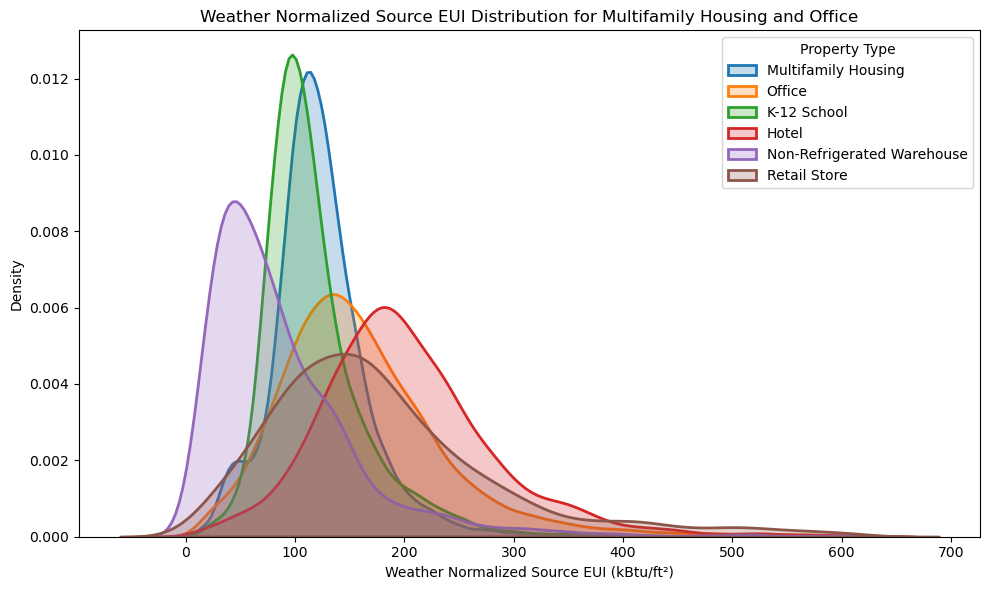

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

categories = ['Multifamily Housing','Office','K-12 School','Hotel','Non-Refrigerated Warehouse','Retail Store']

for category in categories:
    subset = df_nyc_graph[df_nyc_graph['Primary Property Type - Self Selected'] == category]
    sns.kdeplot(
        subset['Weather Normalized Source EUI (kBtu/ft²)'],
        label=category,
        linewidth=2,
        fill=True
    )

plt.xlabel("Weather Normalized Source EUI (kBtu/ft²)")
plt.ylabel("Density")
plt.title("Weather Normalized Source EUI Distribution for Multifamily Housing and Office")
plt.legend(title="Property Type")
plt.tight_layout()

plt.savefig('office_housing_density.png')

plt.show()



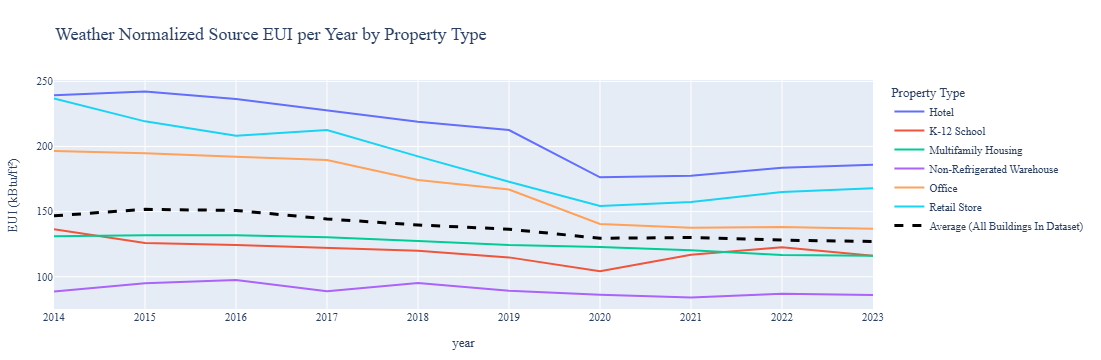

In [39]:
import plotly.express as px
import plotly.graph_objects as go

# Group by property type and year
df_nyc_gb = df_nyc_graph.groupby(['Primary Property Type - Self Selected', 'year'])['Weather Normalized Source EUI (kBtu/ft²)'].mean().reset_index()

# Compute yearly average across all property types
df_avg = df_nyc_simp.groupby('year')['Weather Normalized Source EUI (kBtu/ft²)'].mean().reset_index()

# Plot main figure
fig = px.line(
    df_nyc_gb,
    x="year",
    y="Weather Normalized Source EUI (kBtu/ft²)",
    color="Primary Property Type - Self Selected",
    title="Weather Normalized Source EUI per Year by Property Type",
    labels={"Weather Normalized Source EUI (kBtu/ft²)": "EUI (kBtu/ft²)"}
)

# Add average line trace
fig.add_trace(
    go.Scatter(
        x=df_avg["year"],
        y=df_avg["Weather Normalized Source EUI (kBtu/ft²)"],
        mode="lines",
        name="Average (All Buildings In Dataset)",
        line=dict(color="black", width=3, dash="dash")
    )
)

# Layout styling
fig.update_layout(
    font=dict(family="Times New Roman", size=11),
    title_font=dict(size=18, family="Times New Roman"),
    legend_title_text="Property Type",
    legend=dict(title_font_family="Times New Roman"),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()


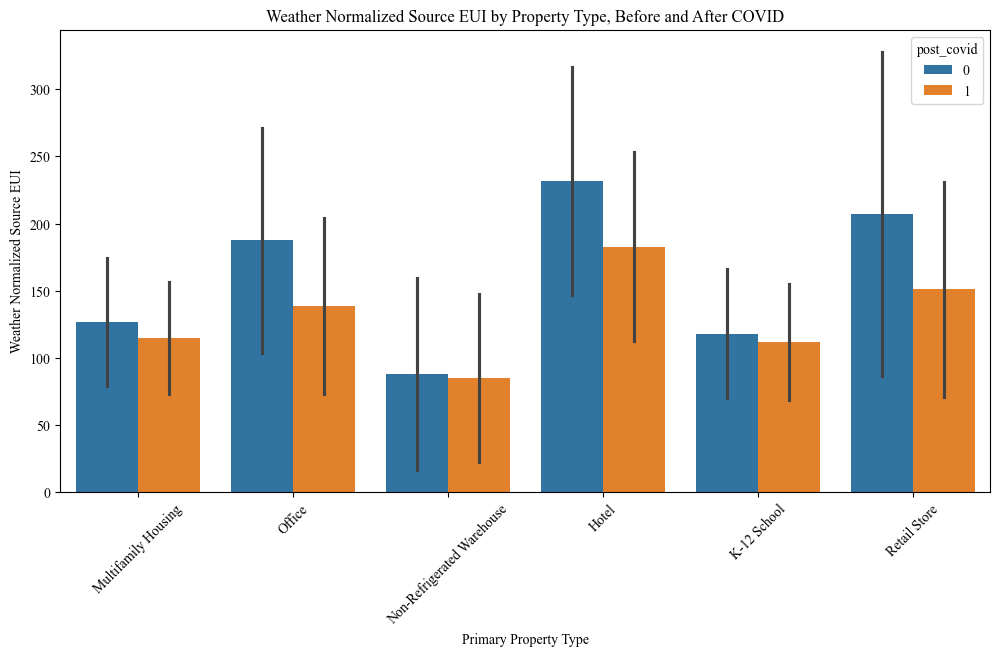

In [131]:
# Plot
plt.figure(figsize=(12, 6))

mpl.rcParams['font.family'] = 'Times New Roman'

sns.barplot(
    data=df_nyc_graph, 
    x='Primary Property Type - Self Selected', 
    y='Weather Normalized Source EUI (kBtu/ft²)', 
    hue='post_covid', 
    errorbar='sd',
)

plt.xticks(rotation=45)
plt.xlabel('Primary Property Type')
plt.ylabel('Weather Normalized Source EUI')
plt.title('Weather Normalized Source EUI by Property Type, Before and After COVID')

plt.savefig('source_eui_barplot.png')

plt.show()

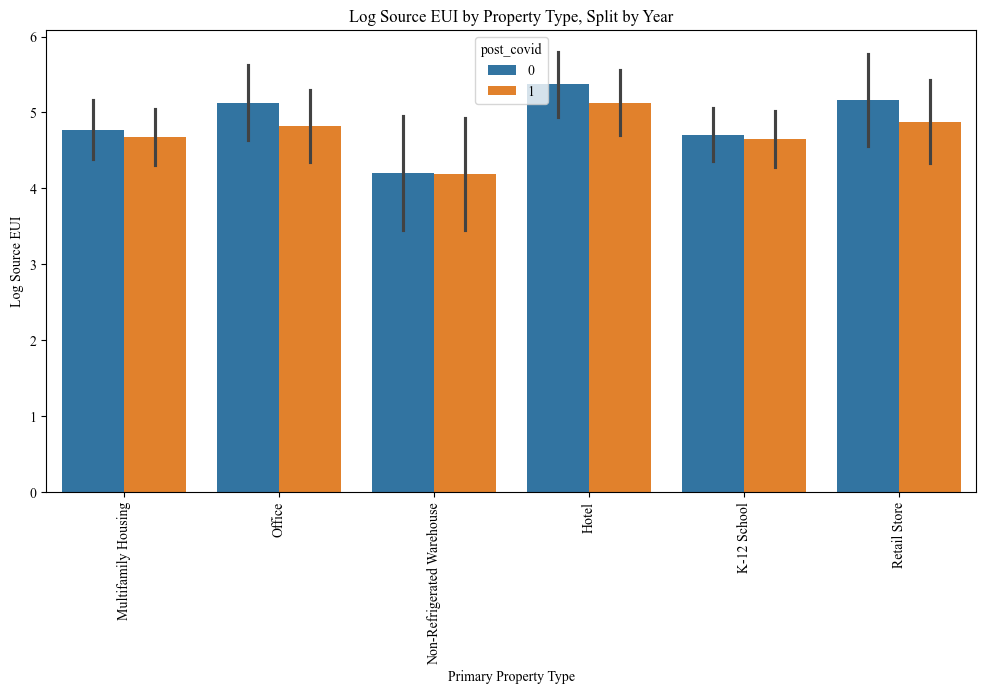

In [132]:
# Plot
plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_nyc_graph, 
    x='Primary Property Type - Self Selected', 
    y='ln_source_eui', 
    hue='post_covid', 
    errorbar='sd'
)

plt.xticks(rotation=90)
plt.xlabel('Primary Property Type')
plt.ylabel('Log Source EUI')
plt.title('Log Source EUI by Property Type, Split by Year')
plt.show()

# Run Regression

In [134]:
# check_features = [
#     'age_bin',
#     'Primary Property Type - Self Selected',
#     'sqft_bin',
#     'numfloors',
#     'electricity_primary',
#     'natural_primary',
#     'steam_primary',
#     'ln_source_eui',
#     'year',
#     'assesstot',
#     'assesstot_persqft',
#     'Weather Normalized Source EUI (kBtu/ft²)'
# ]

check_features = [
    'age',
    'Primary Property Type - Self Selected',
    'sqft',
    'numfloors',
    'Electricity Use (kBtu)_ratio',
    'Natural Gas Use (kBtu)_ratio',
    'District Steam Use (kBtu)_ratio',
    'ln_source_eui',
    'year',
    'assesstot_persqft',
    'assesstot',
    'Weather Normalized Source EUI (kBtu/ft²)'
]
    
df_features = df_nyc_graph[check_features]

In [135]:
# Get encoded
df_features = pd.get_dummies(df_features, columns=['Primary Property Type - Self Selected'])
df_features = df_features.drop(columns=['Primary Property Type - Self Selected_Office'])
df_features = df_features.astype({col: 'float64' for col in df_features.select_dtypes('bool').columns})

df_features = df_features.replace([np.inf, -np.inf], np.nan)  # convert infs to NaN
df_features = df_features.dropna()  # drop any rows with NaNs (should probably adjust this)

df_features_main = df_features.drop('year',axis=1)

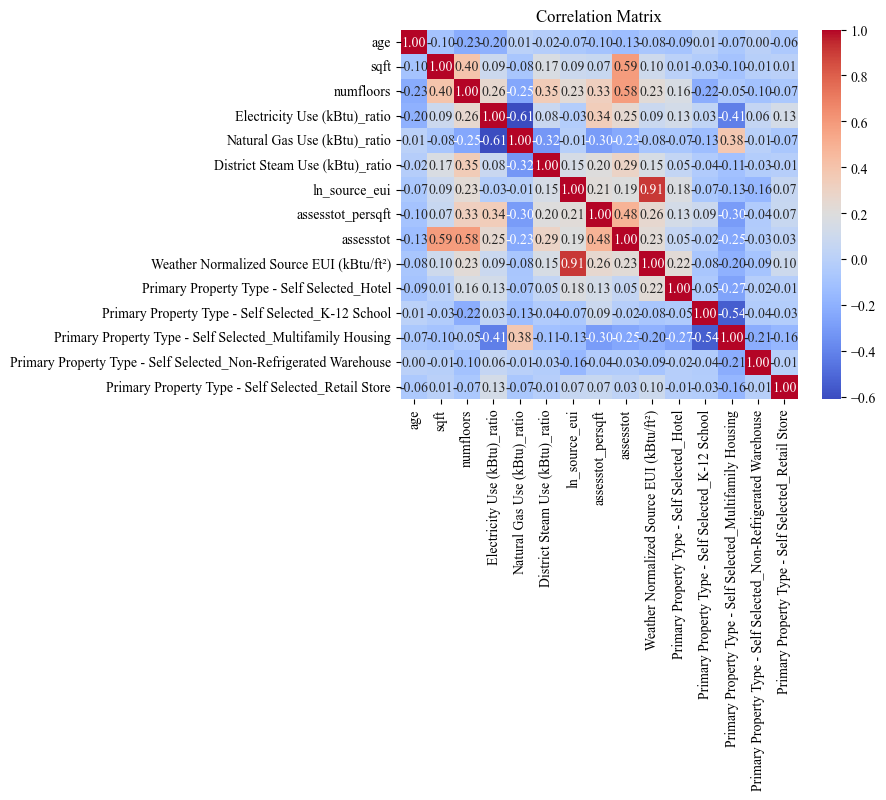

ln_source_eui                                                       1.000000
Weather Normalized Source EUI (kBtu/ft²)                            0.911027
numfloors                                                           0.227326
assesstot_persqft                                                   0.214932
assesstot                                                           0.194752
Primary Property Type - Self Selected_Hotel                         0.176508
District Steam Use (kBtu)_ratio                                     0.147611
sqft                                                                0.088710
Primary Property Type - Self Selected_Retail Store                  0.066381
Natural Gas Use (kBtu)_ratio                                       -0.011115
Electricity Use (kBtu)_ratio                                       -0.028072
age                                                                -0.066899
Primary Property Type - Self Selected_K-12 School                  -0.067142

In [136]:
# Compute correlations
correlations = df_features_main.corr()['ln_source_eui'].sort_values(ascending=False)

# Visualize
sns.heatmap(df_features_main.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

print(correlations)

# Try using raw values of Electricity / Natural Gas instead of ratios

In [137]:
import statsmodels.api as sm

X = df_features_main.drop(columns=['ln_source_eui','Weather Normalized Source EUI (kBtu/ft²)'])
y = df_features_main['ln_source_eui']
X = sm.add_constant(X)  # add intercept

model = sm.OLS(y, X).fit()
print(model.summary())

# Change omitted dummy variable to housing/offices

                            OLS Regression Results                            
Dep. Variable:          ln_source_eui   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     2203.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:55:58   Log-Likelihood:                -58979.
No. Observations:              127816   AIC:                         1.180e+05
Df Residuals:                  127802   BIC:                         1.181e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [138]:
X = df_features_main.drop(columns=['ln_source_eui','Weather Normalized Source EUI (kBtu/ft²)'])
y = df_features_main['Weather Normalized Source EUI (kBtu/ft²)']
X = sm.add_constant(X)  # add intercept

model = sm.OLS(y, X).fit()
print(model.summary())

                                       OLS Regression Results                                       
Dep. Variable:     Weather Normalized Source EUI (kBtu/ft²)   R-squared:                       0.187
Model:                                                  OLS   Adj. R-squared:                  0.186
Method:                                       Least Squares   F-statistic:                     2255.
Date:                                      Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                                              11:55:58   Log-Likelihood:            -6.8228e+05
No. Observations:                                    127816   AIC:                         1.365e+06
Df Residuals:                                        127802   BIC:                         1.365e+06
Df Model:                                                13                                         
Covariance Type:                                  nonrobust                                

In [139]:
# Run on just offices

primary_property_list = [col for col in df_features_main.columns if 'Primary Property Type' in col]

df_offices = df_features_main[df_features_main[primary_property_list].sum(axis=1) == 0].drop(primary_property_list, axis=1)

X = df_offices.drop(columns=['ln_source_eui','Weather Normalized Source EUI (kBtu/ft²)'])
y = df_offices['ln_source_eui']
X = sm.add_constant(X)  # add intercept

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          ln_source_eui   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     206.7
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:55:58   Log-Likelihood:                -9331.1
No. Observations:               14205   AIC:                         1.868e+04
Df Residuals:                   14196   BIC:                         1.875e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [140]:
# Run on just multifamily housing

df_housing = df_features_main[df_features_main['Primary Property Type - Self Selected_Multifamily Housing'] == 1].drop(primary_property_list, axis=1)

X = df_housing.drop(columns=['ln_source_eui','Weather Normalized Source EUI (kBtu/ft²)'])
y = df_housing['ln_source_eui']
X = sm.add_constant(X)  # add intercept

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_source_eui   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     2327.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:55:58   Log-Likelihood:                -34977.
No. Observations:               96688   AIC:                         6.997e+04
Df Residuals:                   96679   BIC:                         7.006e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [141]:
# Now split data into pre and post COVID sets
df_features_pre = df_features[df_features['year'] < 2020].drop('year',axis=1)
df_features_post = df_features[df_features['year'] >= 2020].drop('year',axis=1)

In [142]:
# Run on just multifamily housing
X = df_features_pre.drop(columns=['ln_source_eui','Weather Normalized Source EUI (kBtu/ft²)'])
y = df_features_pre['ln_source_eui']
X = sm.add_constant(X)  # add intercept

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_source_eui   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1534.
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:55:58   Log-Likelihood:                -34228.
No. Observations:               74407   AIC:                         6.848e+04
Df Residuals:                   74393   BIC:                         6.861e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [143]:
# Run on just multifamily housing
X = df_features_post.drop(columns=['ln_source_eui','Weather Normalized Source EUI (kBtu/ft²)'])
y = df_features_post['ln_source_eui']
X = sm.add_constant(X)  # add intercept

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          ln_source_eui   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     817.0
Date:                Mon, 28 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:55:59   Log-Likelihood:                -22708.
No. Observations:               53409   AIC:                         4.544e+04
Df Residuals:                   53395   BIC:                         4.557e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [144]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X = df_features_main.drop(columns=['ln_source_eui','Weather Normalized Source EUI (kBtu/ft²)'])
y = df_features_main['ln_source_eui']

# Split the data first (you didn't have this yet)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Get R² score
r2 = r2_score(y_test, y_pred)
print(f"R2 Score: {r2:.4f}")


R2 Score: 0.6953


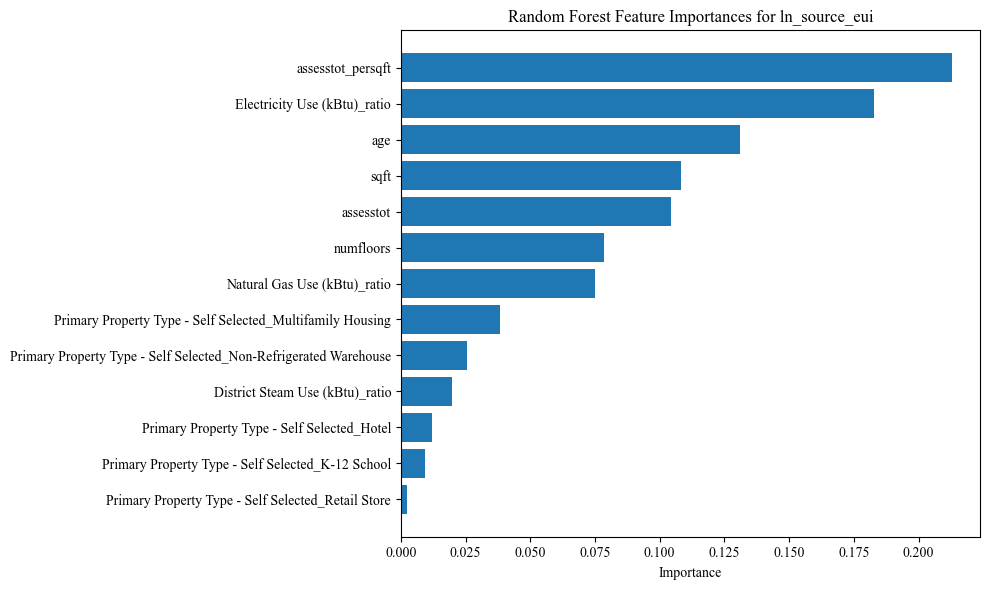

In [145]:
# Feature Importances
importances = rf.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances for ln_source_eui')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [146]:
# Random forest for offices
X = df_features_main.drop(columns=['ln_source_eui','Weather Normalized Source EUI (kBtu/ft²)'])
y = df_features_main['ln_source_eui']